# Packages

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

# Load Data

In [3]:
df = pd.read_csv('../data/swat-2015-data.csv')

In [4]:
print(df.shape)
df.head()

(449919, 53)


,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,28/12/2015 10:00:00 AM,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.8652,1.649953,189.5988,0.000128,1,1,1,Normal
1,28/12/2015 10:00:01 AM,2.446274,522.8860,2,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.8652,1.649953,189.6789,0.000128,1,1,1,Normal
2,28/12/2015 10:00:02 AM,2.489191,522.8467,2,2,1,262.0161,8.394514,328.6337,2.442316,...,2,1,250.8812,1.649953,189.6789,0.000128,1,1,1,Normal
3,28/12/2015 10:00:03 AM,2.534350,522.9645,2,2,1,262.0161,8.394514,328.6337,2.442316,...,2,1,250.8812,1.649953,189.6148,0.000128,1,1,1,Normal
4,28/12/2015 10:00:04 AM,2.569260,523.4748,2,2,1,262.0161,8.394514,328.6337,2.443085,...,2,1,250.8812,1.649953,189.5027,0.000128,1,1,1,Normal


# Process

## 1. Normalization

Here we use `sklearn` package to do normalization, we chooose the `MinMaxScaler()`. 

In [5]:
# Drop time stamp feature, since time format 
# can not be (or not necessary to be) normalized 
df.drop(' Timestamp', axis=1, inplace=True)

# Drop attack feature, since can not be normalized
df.drop('Normal/Attack', axis=1, inplace=True)

from sklearn import preprocessing
processor = preprocessing.MinMaxScaler()
df = processor.fit_transform(df)

## 2. Save to Numpy Format

We prefer using numpy to do the rest series processings. 

In [6]:
np.save('../data/swat-2015-data.npy', df)

## 3. Spectral Residual

We borrow the package from [Y-bar](https://github.com/y-bar)'s Spectral Residual tool.

Here we choose to process on 29 Dec 2015's data. 

Ref link: [https://github.com/y-bar/ml-based-anomaly-detection](https://github.com/y-bar/ml-based-anomaly-detection).

In [7]:
# Reload as numpy.array
data = np.load('../data/swat-2015-data.npy')

# Dataset Start Time and End Time
df_time_start = np.array('2015-12-28T10:00:00', dtype=np.datetime64)
df_time_end = np.array('2016-01-02T02:59:59', dtype=np.datetime64)
time_start = np.array('2015-12-29T00:00:00', dtype=np.datetime64)
time_end = np.array('2015-12-30T00:00:00', dtype=np.datetime64)

# Index for 29 Dec 2015's data
idx_start = int((time_start - df_time_start) / np.timedelta64(1, 's'))
idx_end = int((time_end - df_time_start) / np.timedelta64(1, 's'))

# Sample data on 29 Dec 2015
sample = data[idx_start:idx_end, 1]

In [8]:
import sys; sys.path.append('../')
from src.silency import Silency

# Init spectral residual processor
# Args follow original repo's suggestion:
# - amp_window_size: should less than period
# - series_window_size: should less than period
# - score_window_size: should larger than perido
processor = Silency(amp_window_size=1000, 
                    series_window_size=1000, 
                    score_window_size=5000)

# Processed by spectral residual method
anomaly_score = processor.generate_anomaly_score(sample)

/home/cbhua/Github/tool-swat-preprocess/notebook/../src/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


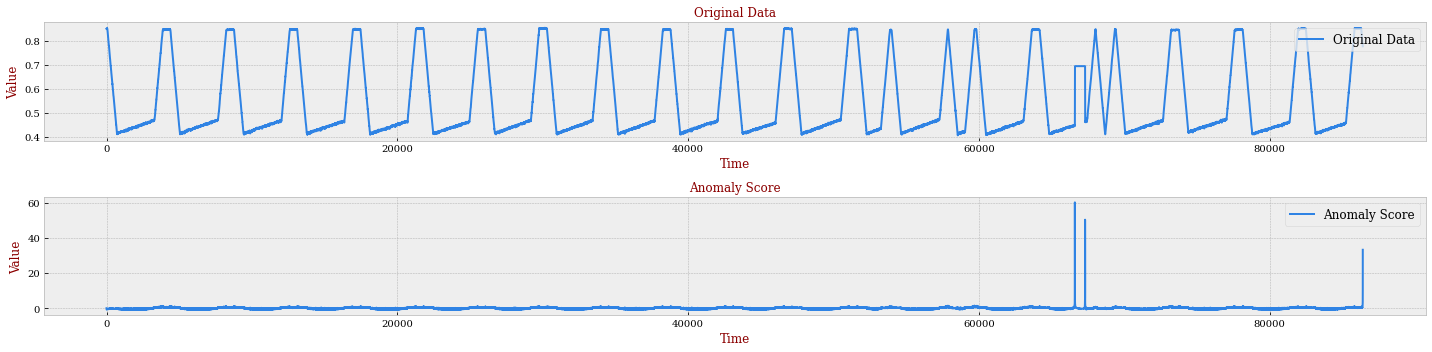

In [9]:
x = range(idx_end - idx_start)

with plt.style.context('bmh'):
    font = {'color': 'darkred', 'size': 12, 'family': 'serif'}
    font_legend = {'size': 12, 'family': 'serif'}

    fig, axs = plt.subplots(2, 1, figsize=(20, 5))

    axs[0].plot(x, sample, label='Original Data', color='#2f83e4')
    axs[0].set_xlabel('Time', fontdict=font)
    axs[0].set_ylabel('Value', fontdict=font)
    axs[0].set_title('Original Data', fontdict=font)
    axs[0].legend(loc='upper right', prop=font_legend)
    labels = axs[0].get_xticklabels() + axs[0].get_yticklabels()
    [label.set_fontname('serif') for label in labels]

    axs[1].plot(x, anomaly_score, label='Anomaly Score', color='#2f83e4')
    axs[1].set_xlabel('Time', fontdict=font)
    axs[1].set_ylabel('Value', fontdict=font)
    axs[1].set_title('Anomaly Score', fontdict=font)
    axs[1].legend(loc='upper right', prop=font_legend)
    labels = axs[1].get_xticklabels() + axs[1].get_yticklabels()
    [label.set_fontname('serif') for label in labels]

plt.tight_layout()
plt.savefig('../fig/swat-2015-sr-sample.png')

### Multi Process

Here we will process SR on every features. For SWaT dataset, we can see all features have similar periods, so here we can use the same processor setting. 

In [ ]:
anomaly_score_list = []
for i in range(51):
    sample = data[idx_start:idx_end, i]
    anomaly_score = processor.generate_anomaly_score(sample)
    anomaly_score_list.append(anomaly_score)

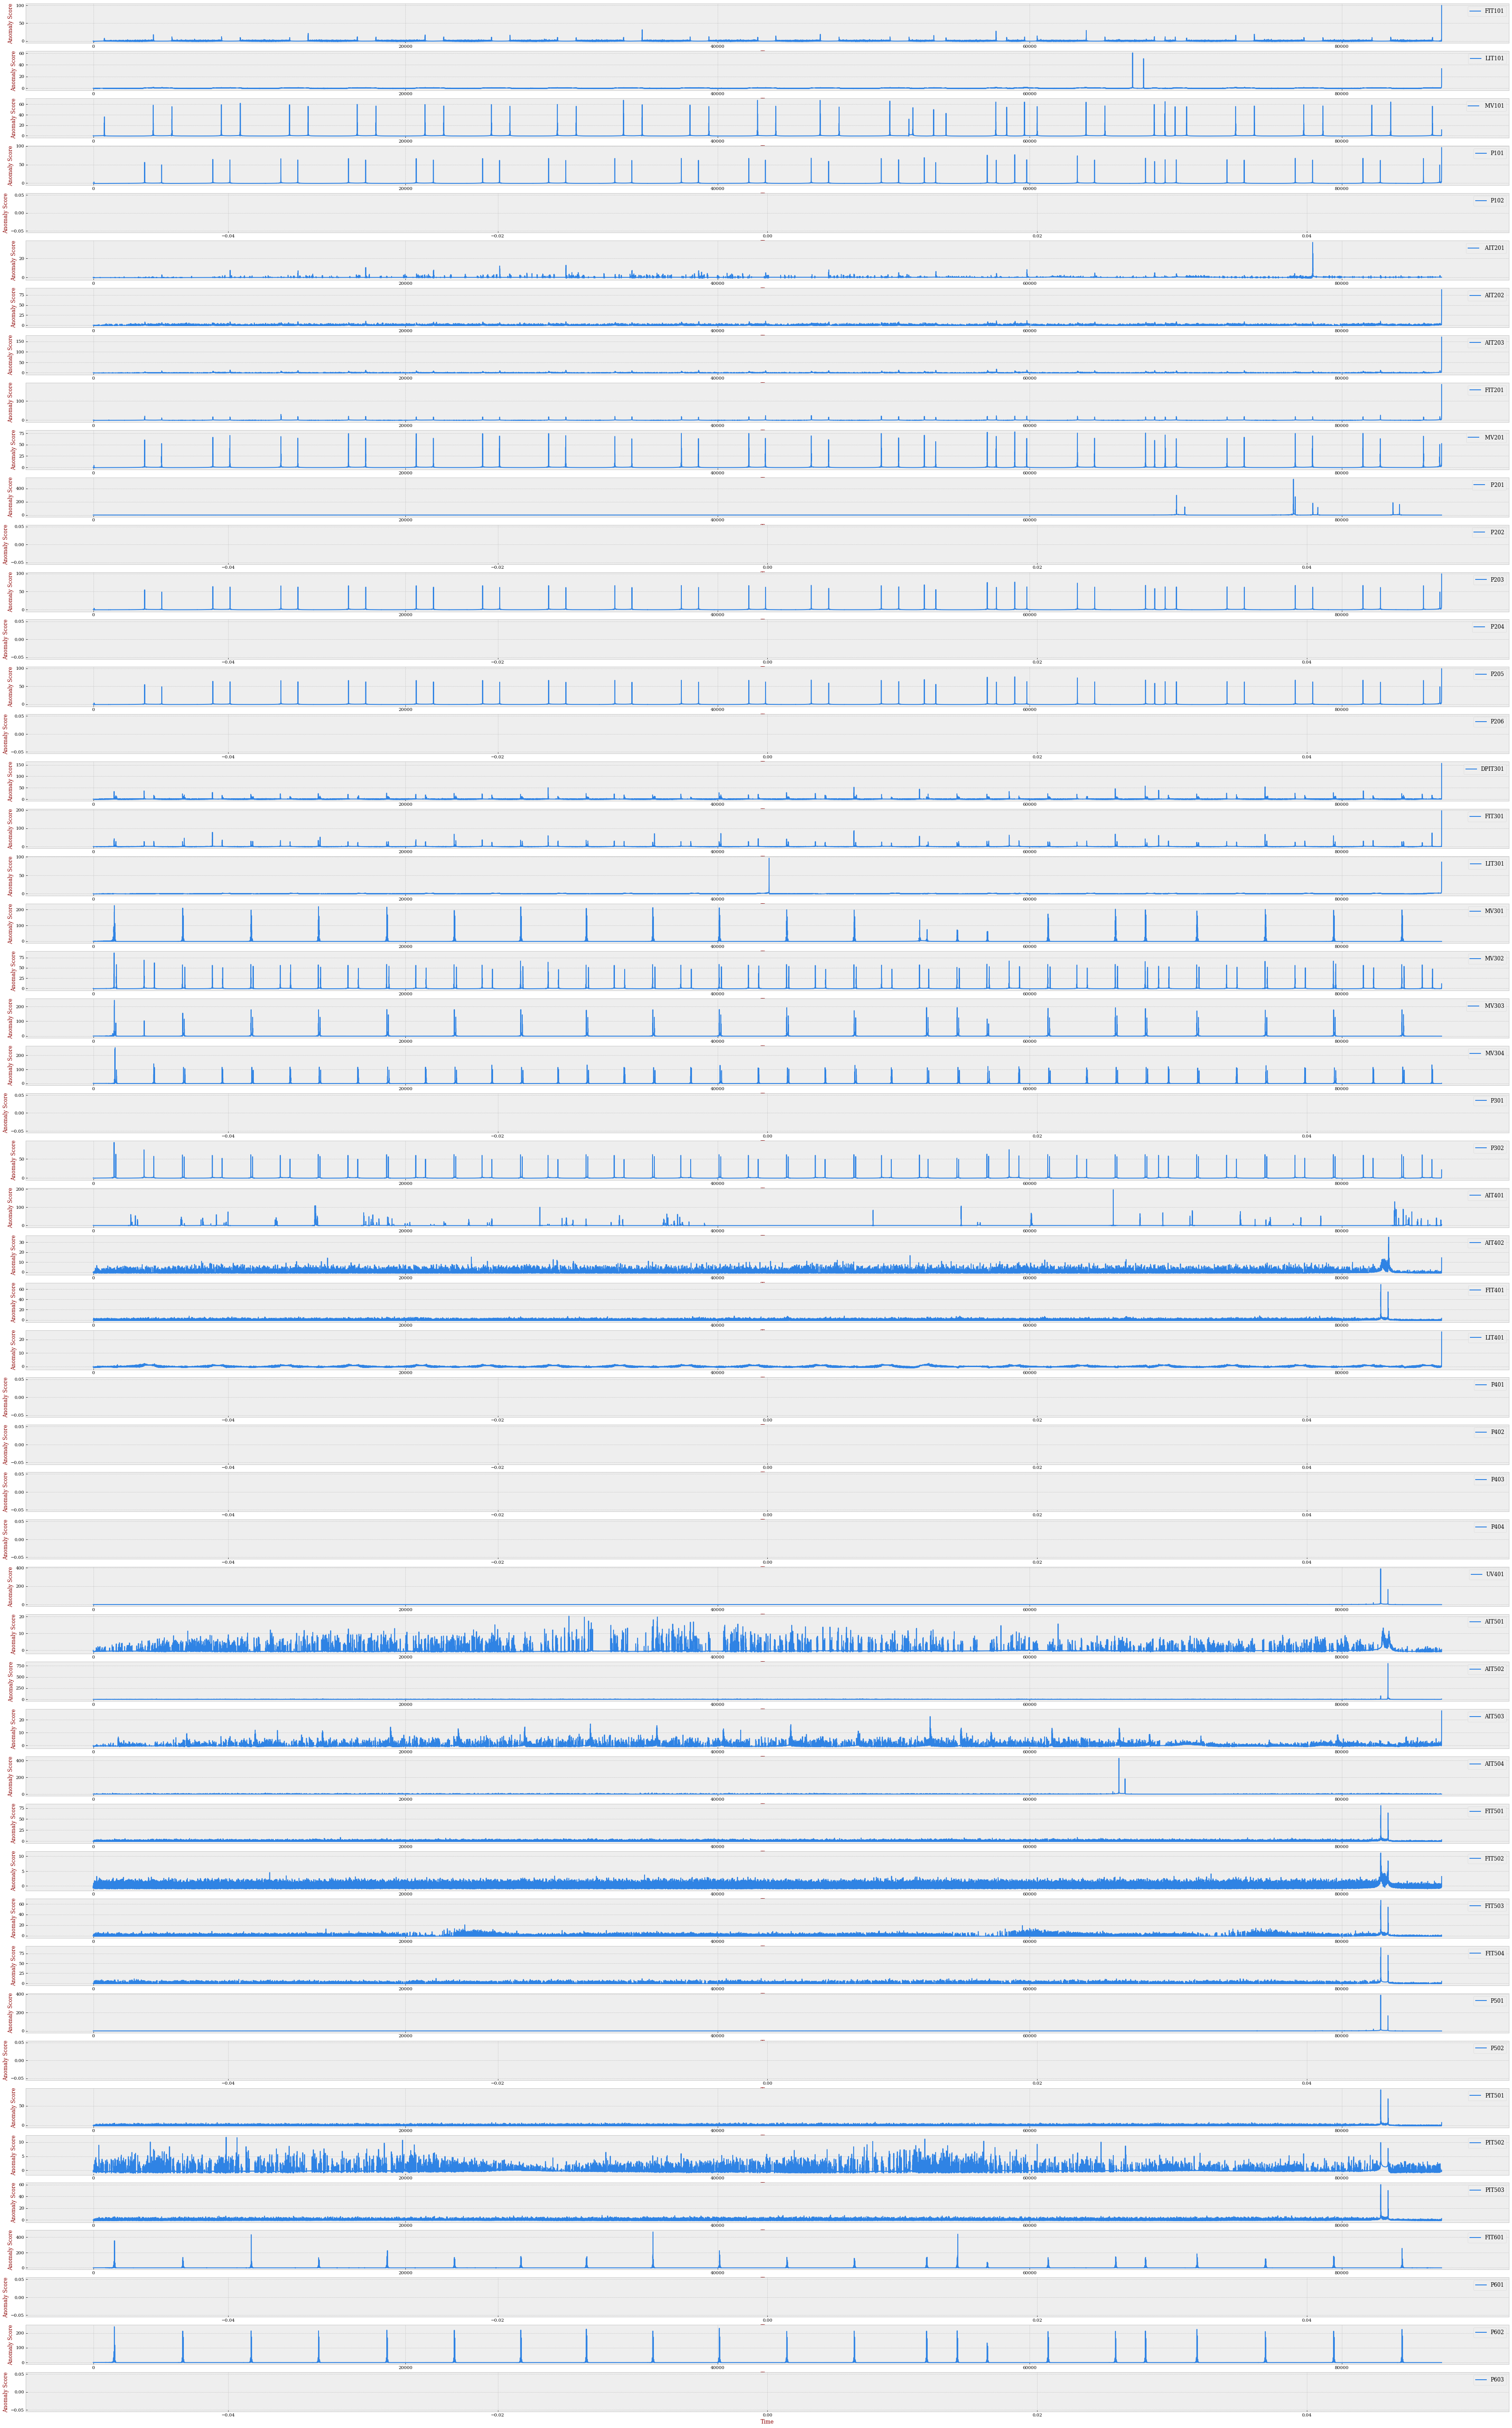

In [11]:
df = pd.read_csv('../data/swat-2015-data.csv')
x = range(idx_end - idx_start)

with plt.style.context('bmh'):
    font = {'color': 'darkred', 'size': 12, 'family': 'serif'}
    font_legend = {'size': 12, 'family': 'serif'}

    fig, axs = plt.subplots(51, 1, figsize=(60, 100))

    for i in range(51):
        axs[i].plot(x, anomaly_score_list[i], label=df.columns[i+1], color='#2f83e4')
        axs[i].set_xlabel('Time', fontdict=font)
        axs[i].set_ylabel('Anomaly Score', fontdict=font)
        axs[i].legend(loc='upper right', prop=font_legend)
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels()
        [label.set_fontname('serif') for label in labels]

plt.savefig('../fig/swat-2015-sr.png')